# Menu <a class="anchor" id="menu"></a>
* [1 Préparation du jeu de données](#models_prepare)
    * [1.1 Découpage du jeu de données](#models_prepare_split)
    * [1.2 Encodage des variables qualitatives](#models_prepare_encode)
    * [1.3 Imputation des valeurs manquantes](#models_prepare_impute)
    * [1.4 Normalisation](#models_prepare_normalize)
    * [1.5 Choix des outils de mesure](#models_prepare_metrics)
* [2. Algorithmes sans optimisation](#models)
    * [2.1 (Naïve) DummyClassifier](#models_dummy)
    * [2.2 (Linear) Logistic Regression](#models_linear)
    * [2.3 (Non-Linear) Decision Tree](#models_decision_tree)
    * [2.4 (Non-Linear) K-Nearest Neighbors](#models_knn)
    * [2.5 (Ensemble) Random Forest](#models_random_forest)
    * [2.6 (Ensemble) XGBoost](#models_xgboost)
* [3. Recherche des meilleurs paramètres avec `GreadSearchCV`](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Améliorer les modèles avec `class_weigth`](#models_balanced)
    * [4.1 Logistic Regression](#models_linear_balanced)
    * [4.2 Decision Tree](#models_decision_tree_balanced)
    * [4.3 Random Forest](#models_random_forest_balanced)
    * [4.4 XGBoost Classifier](#models_xgboost_balanced)
* [5. Améliorer les modèles avec `SMOT`](#models_smot)
    * [5.1 Logistic Regression](#models_linear_smot)
    * [5.2 Decision Tree](#models_decision_tree_smot)
    * [5.3 K-Nearest Neighbors](#models_knn_smot)
    * [5.3 Random Forest](#models_random_forest_smot)
    * [5.4 XGBoost Classifier](#models_xgboost_smot)
* [6. Choix des modèles pour la suite](#models_choice)

# Mise en place

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px

np.random.seed(0) # Seed the unexpected randomness of this world

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [5]:
sample_size_base = 30000
sample_size_grid = 30000
data_work = data_application_train[:sample_size_base].copy()

# Préparons le jeu de données <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Découpage du jeu de données  <a class="anchor" id="models_prepare_split"></a> [⇪](#menu)

> Il existe au moins 2 approches pour le découpage du jeu de données.
> 1. On peut le découper en 3 sous-ensembles `Train`, `Validation` et `Test`.
> 2. On peut le découper en 2 sous-ensembles `Train` et `Test`.
>
> Idéalement, il nous faut idéalement les trois jeux de données:
> - Le `Train` set pour entrainer les différents modèles *(différents algorithmes ou paramètres)*.
> - Le `Validation` set pour choisir le modèle le plus performant sur des données non-vues lors de l'entrainement.
> - Le `Test` set pour estimer la généralisation du modèle choisi *(une fois ré-entrainé avec l'ensemble training+validation)*, et donc vérifier que les scores de validation ne sont pas des overfit ou underfit.
>
> Mais lorsque l'on utiliser une méthode de **cross-validation** comme le K-Fold ou le StratifiedKFold, on peut se contenter d'un découpage en 2 sous jeu de données, car le jeu d'entrainement est alors découper en k sections qui sont tour à tour utilisées en tant que set de `Validation` pour que les k-1 autres sections sont utilisées pour en tant que `Train` set *(ce qui permet d'utiliser une plus grande fraction des données pour l'entrainement final)*.
>
> Dans ce projet, il est utile (et demandé) de faire de la cross-validation, aussi allons nous utiliser un découpage en deux sous ensemble `Train` et `Test`.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_full = data_work.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_work['TARGET']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [9]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


### Encodage des données non-numériques <a class="anchor" id="models_prepare_encode"></a> [⇪](#menu)
> Pour pouvoir travailler, les algorithmes ont besoin de données numériques. Il nous faut donc transformer celles qui ne le sont pas avant de pouvoir entrainer et évaluer des modèles.
>
> Il existe plusieurs approches comme le LabelEncoder, l'OrdinalEncoder ou encore le OneHotEncoder.
> - Le `LabelEncoder` est adapté pour transformer la variable cible tout en restant sur une seule colonne.
> - L'`OrdinalEncoder` est adapté pour transformer les features tout en restant sur une seule colonne.
> - Le `OneHotEncoder` est adapté pour transformer les features en valeurs binaires sur plusieurs colonnes.
>
> Pour les variables catégorielles où il n'existe pas de relation ordinale, l'`OrdinalEncoder` peut au mieux ne pas être suffisant, ou au pire induire le modèle en erreur. Dans ce cas, il convient d'utiliser le `OneHotEncoder`.
>
> Les variables qui pourraient être considérée comme ordindal d'après notre EDA sont:
> - `NAME_EDUCATION_TYPE`
> - `WEEKDAY_APPR_PROCESS_START`
>
> Nous allons donc appliquer un `OrdinalEncoder` sur ces deux variables et un `OneHotEncoder` sur le reste. La variable cible elle n'a pas besoin d'être encodée car ce sont déjà des 0 et des 1.

In [10]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder #, LabelEncoder

In [11]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = [x for x in ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'] if x in data.columns]
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_model):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### On entraine les deux encoders sur le `train` set

In [12]:
oe_model, ohe_model = fit_labels(X_train)

#### On transforme les données des `training` et `testing` sets

In [13]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations des données manquantes <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [15]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

#### On entraine l'imputer sur le `train` set

In [16]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

#### On transforme les données des `training` et `testing` sets

In [17]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)

(25500, 238) <class 'pandas.core.frame.DataFrame'>
(4500, 238) <class 'pandas.core.frame.DataFrame'>


#### Regardons le taux de remplissage des colonnes après imputations

<AxesSubplot:>

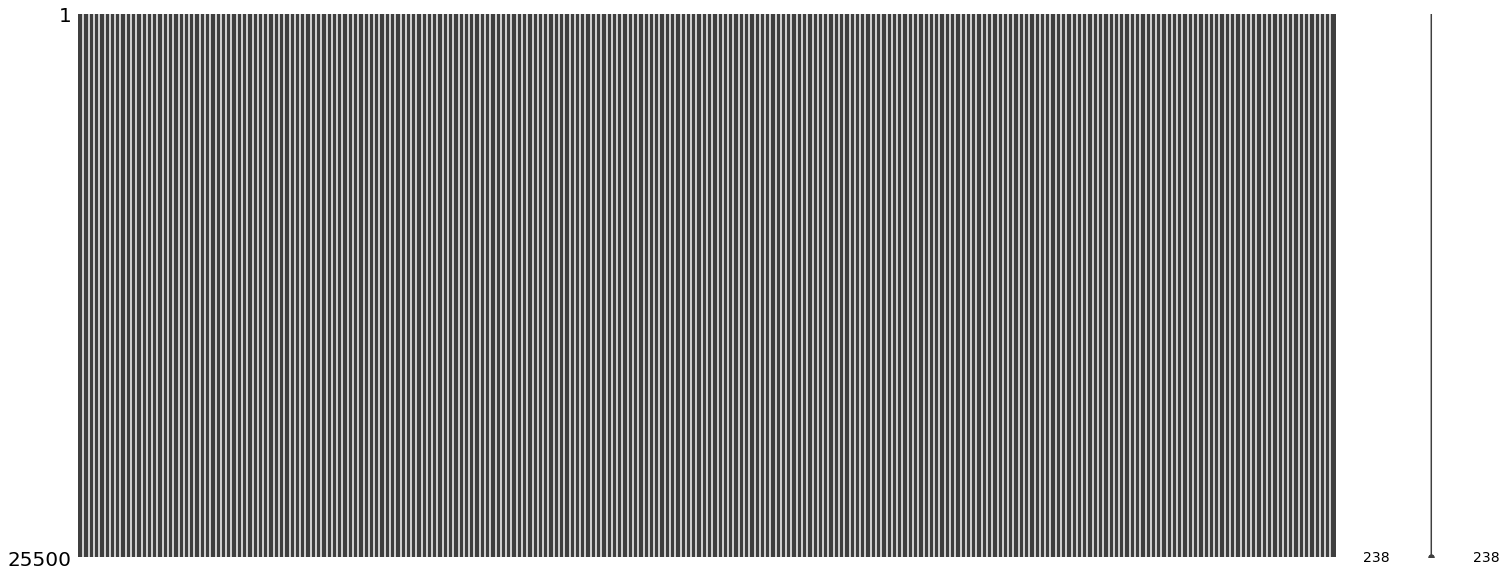

In [18]:
import missingno as msno
msno.matrix(X_train)

### Normalisation du jeu de données <a class="anchor" id="models_prepare_normalize"></a> [⇪](#menu)

> Certains algorithmes de Machine Learning sont sensibles au changement d'échelle des features *(algorithmes basés sur la descente de gradient, algorithmes basés sur la distance)* alors que d'autres *(algorithmes basés sur les arbres...)* y sont pratiquement insensibles.
>
> Comme nous allons essayer plusieurs algorithmes différents, il convient de rendre nos données compatibles avec le plus grand nombre d'algorithmes possibles, donc de toutes les mettre sur une échelle à peu près semblable.
>
> Il existe plusieurs approches pour adapter les données:
> - Le `MinMaxScaler` qui réduit l'intervalle de manière à ce qu'il soit compris entre 0 et 1 *(ou entre -1 et 1 s'il y a des valeurs négatives)*.
> - Le `StandardScaler` qui met à l'échelle les valeurs de sorte que la distribution soit centrée autour de 0, avec un écart-type de 1. *(le `Normalizer` fait la même chose avec les lignes au lieu des colonnes)*.
> - Le `RobustScaler` qui réduit l'intervalle de manière à ce qu'il soit compris entre 0 et 1 *(ou entre -1 et 1 s'il y a des valeurs négatives)* mais en utilisant l'écart interquartile, de sorte qu'il soit plus résistant aux valeurs aberrantes.

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

#### On entraine le scaler sur le `train` set

In [21]:
model_scaler = fit_normalizer(X_train)

#### On transforme les données des `training` et `testing` sets

In [22]:
X_train = normalize(X_train, model_scaler)
X_test = normalize(X_test, model_scaler)

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

> Nous devons pour cela choisir nos **outils de mesure**.
>
> L'`accuracy` est souvent utilisé pour des modèles de classification, mais c'est en général insuffissant et il faut faire attention à la `precision` et au `recall`. Optimiser des modèles sur la base de plusieurs mesures différentes n'est pas choses aidée, et il est donc habituellement recommandé d'utiliser le `F1-score` qui calcul la moyenne harmonique entre la `precision` et le `recall`.
>
> Cependant, nous sommes ici dans un cas où **le jeu de données est déséquilibré** en faveur des valeurs négatives *(le client ne fait pas défaut)*, et le `F1-score` n'est pas forcement un bon choix avec un tel jeu de données.
>
> Dans un tel cas, il convient d'utiliser des mesures moins sensibles au déséquilibre des classes.
> - Le `Precision-Recall AUC` score est approprié pour les jeux de données très déséquilibré *(ce qui est le cas ici)*, mais il va donner plus de poids à que la classe positive qu'à la classe négative.
> - Le `ROC AUC` score est approprié pour les jeux de données peu ou modérement déséquilibrés, et il va donner autant d'importance à la classe positive qu'à la classe négative.
>
> Les **True Positives** seront des clients que l'on aura considéré comme non solvable avec raison *(donc on **évite une perte**)*.<br>
> Les **True Negatives** seront des clients que l'on aura considéré comme solvable avec raison *(donc on **gagne de l'argent**)*.<br>
> Les **False Positives** seront des clients que l'on aura considéré comme non solvable à tord *(donc on **loupe de l'argent**)*.<br>
> Les **False Negatives** seront des clients que l'on aura considéré comme solvable à tord *(donc on **perd de l'argent**)*.
>
> Dans notre cas, le plus important est de minimiser les pertes d'argent donc les **FN**, mais il semble au moins aussi important de gagner de l'argent et donc de maximiser les **TN**.
>
> On va donc utiliser le `ROC AUC` comme mesure principale, mais enregistrer les autres pour pouvoir tout de même garder un oeil dessus.


In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [24]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [25]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [26]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [27]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [28]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [29]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [30]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [31]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [32]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV # --> trop lent


def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=0)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{scoring.upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{scoring.upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [33]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [34]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [35]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

# Essayons quelques algorithmes sans optimisation <a class="anchor" id="models"></a> [⇪](#menu)

## 1. Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [36]:
from sklearn.dummy import DummyClassifier

In [37]:
model_name = "DummyClassifier"

In [38]:
grd_dummy = fit_model( 
    model_name,
    DummyClassifier(),
    param_grid={ 'random_state':[0], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5171
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4494
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5116
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4602
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4620

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4801 (std:0.0284)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier --------------------------------------------------------------------------------

             ROC_AUC : 0.4905
                  F1 : 0.0666
            ACCURACY : 0.8442
           PRECISION : 0.0639
              RECALL : 0.0694
   AVERAGE_PRECISION : 0.0789

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.06      0.07      0.07       360

      accuracy                           0.84      4500
     macro avg       0.49      0.49      0.49      4500
  weighted avg       0.85  

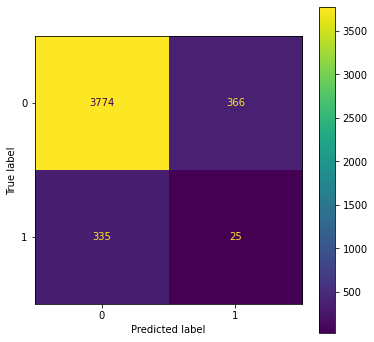

--- ROC AUC ---------------------------------------------------------------------------------------- 



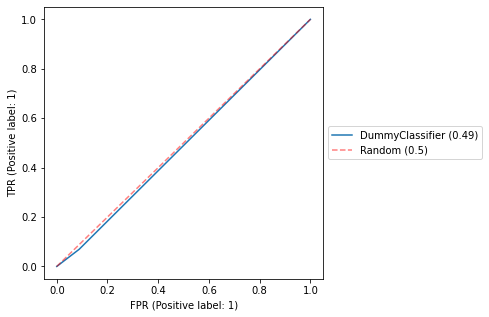

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



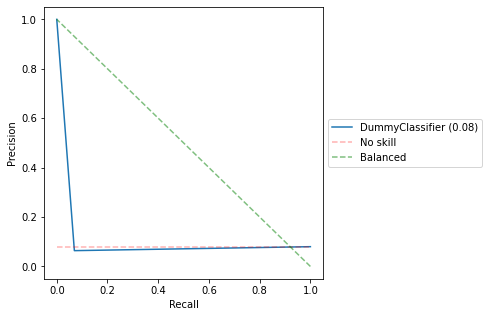

In [39]:
get_scores(model_name, **grd_dummy, register=True)

## 2. Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
model_name = "Basic LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid={ 'random_state':[0], 'max_iter':[3000] },  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4115
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6895
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6447
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6335
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6726

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6103 (std:0.1014)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression -----------------------------------------------------------------------

             ROC_AUC : 0.7330
                  F1 : 0.0055
            ACCURACY : 0.9191
           PRECISION : 0.1667
              RECALL : 0.0028
   AVERAGE_PRECISION : 0.1999

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.17      0.00      0.01       360

      accuracy                           0.92      4500
     macro avg       0.54      0.50      0.48      4500
  weighted avg       0.86  

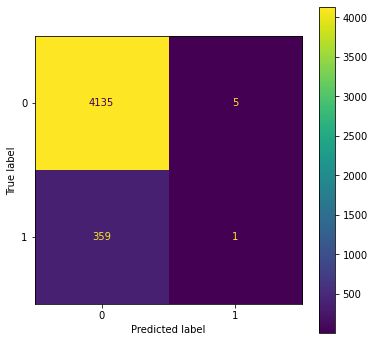

--- ROC AUC ---------------------------------------------------------------------------------------- 



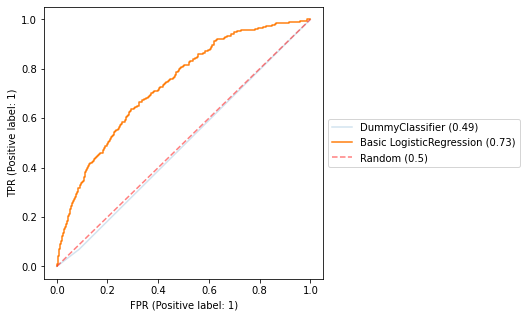

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



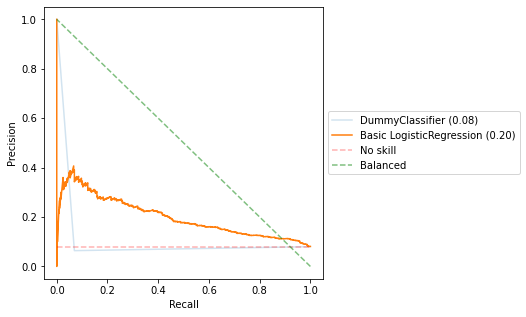

In [42]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [43]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24287028518859247) for this model is reached with a threshold of 0.241


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression [w/thresholding] ------------------------------------------------------

             ROC_AUC : 0.7330
                  F1 : 0.2039
            ACCURACY : 0.8993
           PRECISION : 0.2775
              RECALL : 0.1611
   AVERAGE_PRECISION : 0.1999

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      4140
Prediction = 1       0.28      0.16      0.20       360

      accuracy                           0.90      4500
     macro avg       0.60      0.56      0.58      4500
  weighted avg       0.88  

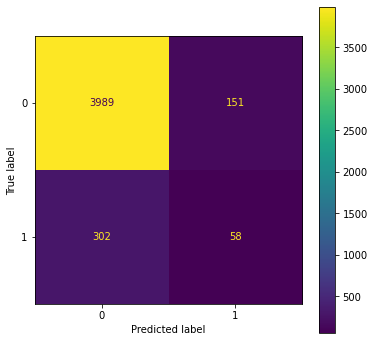

In [44]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Essayons un algorithme non-linéaire - Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
model_name = "Basic DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4670
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5347
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5336
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5133
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4457

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4988 (std:0.0362)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic DecisionTreeClassifier -------------------------------------------------------------------

             ROC_AUC : 0.5213
                  F1 : 0.1224
            ACCURACY : 0.8471
           PRECISION : 0.1132
              RECALL : 0.1333
   AVERAGE_PRECISION : 0.0844

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.11      0.13      0.12       360

      accuracy                           0.85      4500
     macro avg       0.52      0.52      0.52      4500
  weighted avg       0.86  

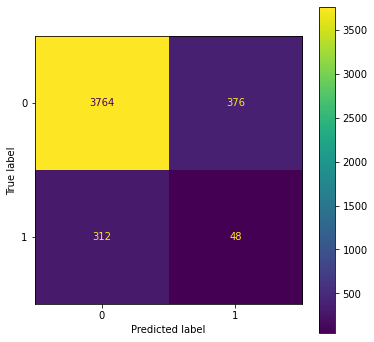

--- ROC AUC ---------------------------------------------------------------------------------------- 



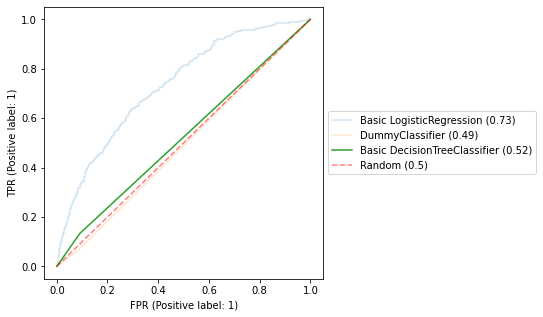

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



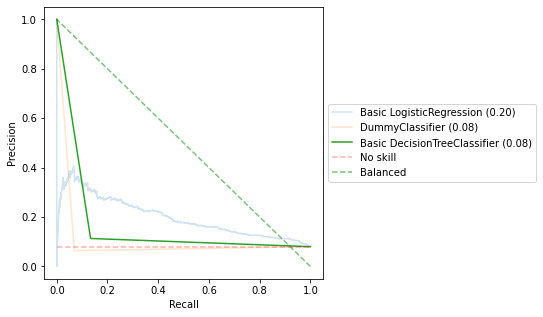

In [47]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [48]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (1.0) for this model is reached with a threshold of 0.999


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic DecisionTreeClassifier [w/thresholding] --------------------------------------------------

             ROC_AUC : 0.5213
                  F1 : 0.1224
            ACCURACY : 0.8471
           PRECISION : 0.1132
              RECALL : 0.1333
   AVERAGE_PRECISION : 0.0844

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.11      0.13      0.12       360

      accuracy                           0.85      4500
     macro avg       0.52      0.52      0.52      4500
  weighted avg       0.86  

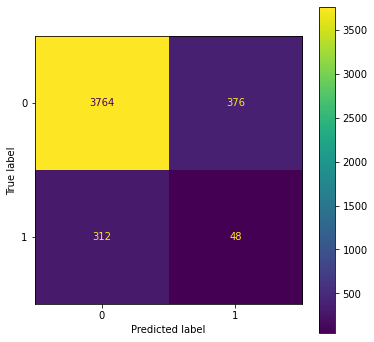

In [49]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Essayons un autre algorithme non-linéaire - KNN *(k-nearest neighbors)* <a class="anchor" id="models_knn"></a> [⇪](#menu)

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
model_name = "Basic KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid={},  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4866
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6527
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5220
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4972
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5285

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5374 (std:0.0597)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic KNeighborsClassifier ---------------------------------------------------------------------

             ROC_AUC : 0.5411
                  F1 : 0.0103
            ACCURACY : 0.9147
           PRECISION : 0.0714
              RECALL : 0.0056
   AVERAGE_PRECISION : 0.0890

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.07      0.01      0.01       360

      accuracy                           0.91      4500
     macro avg       0.50      0.50      0.48      4500
  weighted avg       0.85  

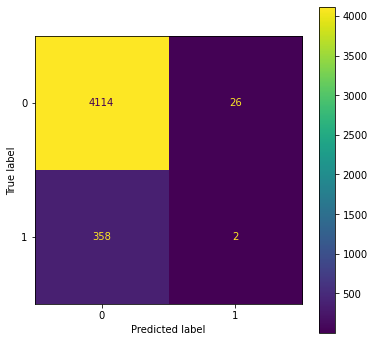

--- ROC AUC ---------------------------------------------------------------------------------------- 



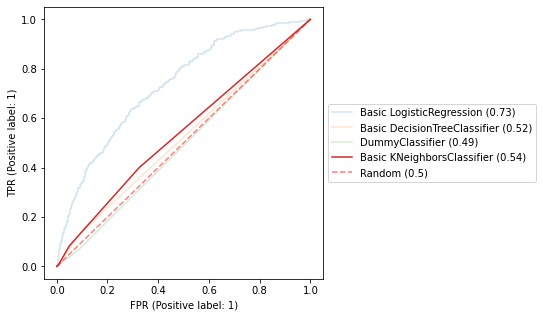

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



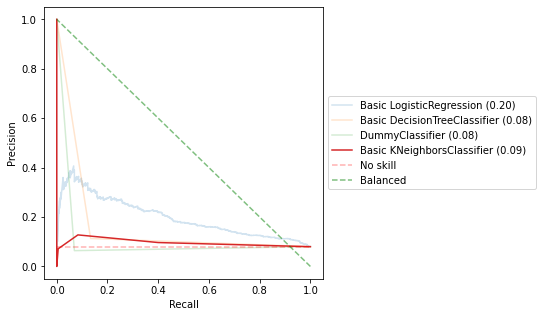

In [52]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [53]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.38864755285259195) for this model is reached with a threshold of 0.389


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic KNeighborsClassifier [w/thresholding] ----------------------------------------------------

             ROC_AUC : 0.5411
                  F1 : 0.1008
            ACCURACY : 0.8811
           PRECISION : 0.1277
              RECALL : 0.0833
   AVERAGE_PRECISION : 0.0890

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.95      0.94      4140
Prediction = 1       0.13      0.08      0.10       360

      accuracy                           0.88      4500
     macro avg       0.53      0.52      0.52      4500
  weighted avg       0.86  

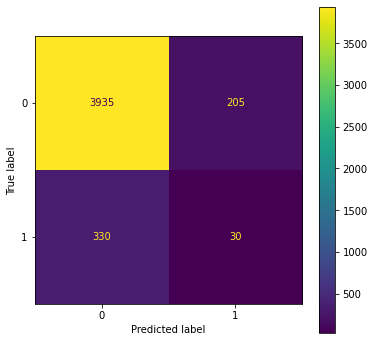

In [54]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 5. Essayons un algorithme d'ensemble - Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
model_name = "Basic RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5391
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5945
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5769
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6406
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6427

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5988 (std:0.0393)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic RandomForestClassifier -------------------------------------------------------------------

             ROC_AUC : 0.6861
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1708

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

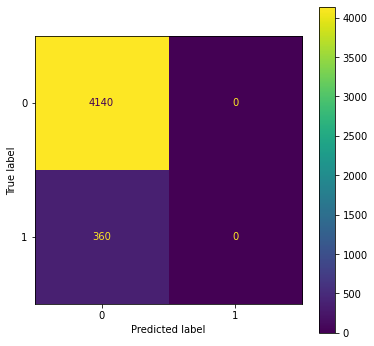

--- ROC AUC ---------------------------------------------------------------------------------------- 



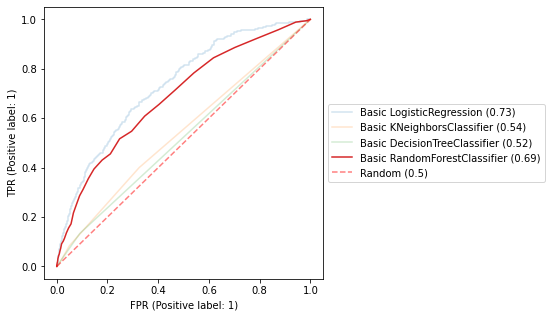

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



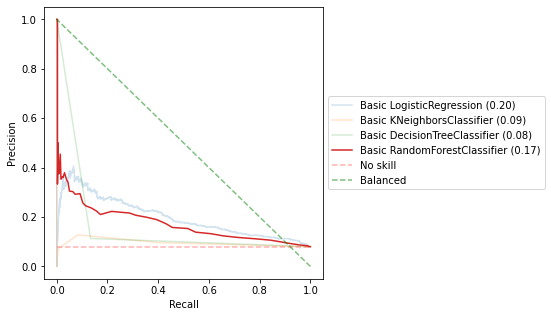

In [57]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [58]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7118537200504413) for this model is reached with a threshold of 0.68


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic RandomForestClassifier [w/thresholding] --------------------------------------------------

             ROC_AUC : 0.6861
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1708

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

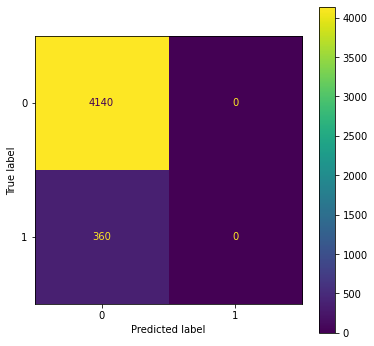

In [59]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Essayons un autre algorithme d'ensemble - XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [60]:
from xgboost import XGBClassifier

In [61]:
model_name = "Basic XGBClassifier"

param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
}

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6166
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7528
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6923
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6600
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7024

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6848 (std:0.0453)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic XGBClassifier ----------------------------------------------------------------------------

             ROC_AUC : 0.7137
                  F1 : 0.1117
            ACCURACY : 0.9187
           PRECISION : 0.4423
              RECALL : 0.0639
   AVERAGE_PRECISION : 0.2145

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.44      0.06      0.11       360

      accuracy                           0.92      4500
     macro avg       0.68      0.53      0.53      4500
  weighted avg       0.89  

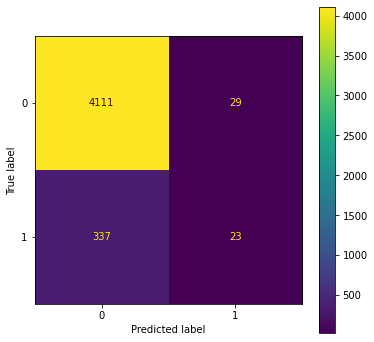

--- ROC AUC ---------------------------------------------------------------------------------------- 



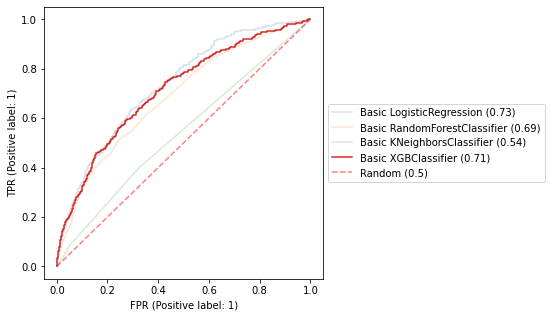

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



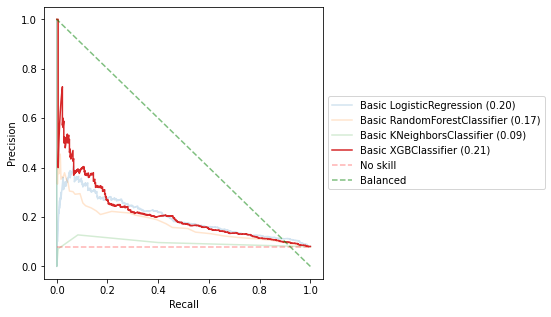

In [62]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [63]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.5625879043600562) for this model is reached with a threshold of 0.561


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic XGBClassifier [w/thresholding] -----------------------------------------------------------

             ROC_AUC : 0.7137
                  F1 : 0.0724
            ACCURACY : 0.9202
           PRECISION : 0.5185
              RECALL : 0.0389
   AVERAGE_PRECISION : 0.2145

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.52      0.04      0.07       360

      accuracy                           0.92      4500
     macro avg       0.72      0.52      0.52      4500
  weighted avg       0.89  

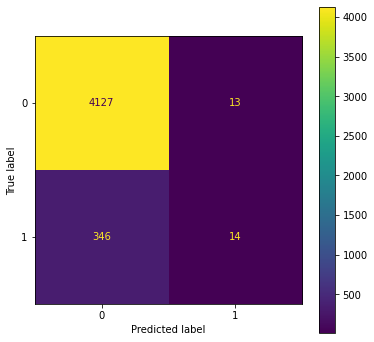

In [64]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 7. Revue des scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [65]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Basic')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
1,Basic LogisticRegression,0.732972,0.005464,0.002778
3,Basic DecisionTreeClassifier,0.521256,0.122449,0.133333
5,Basic KNeighborsClassifier,0.541067,0.010309,0.005556
7,Basic RandomForestClassifier,0.686125,0.000000,0.000000
9,Basic XGBClassifier,0.713682,0.111650,0.063889


In [66]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Basic')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
2,Basic LogisticRegression [w/thresholding],0.732972,0.203866,0.161111
4,Basic DecisionTreeClassifier [w/thresholding],0.521256,0.122449,0.133333
6,Basic KNeighborsClassifier [w/thresholding],0.541067,0.100840,0.083333
8,Basic RandomForestClassifier [w/thresholding],0.686125,0.000000,0.000000
10,Basic XGBClassifier [w/thresholding],0.713682,0.072351,0.038889


In [67]:
sms.send("Basic done", stop=False)

# Recherche des meilleurs paramètres avec GreadSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [68]:
param_grid = [
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [69]:
model_name = "Grid LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4973
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6387
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6044
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5994
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6013

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5882 (std:0.0595)

----------------------------------------------------------------------------------------------------


In [70]:
grd_log['grid'].best_params_

{'C': 0.1,
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid LogisticRegression ------------------------------------------------------------------------

             ROC_AUC : 0.7338
                  F1 : 0.0000
            ACCURACY : 0.9193
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2046

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

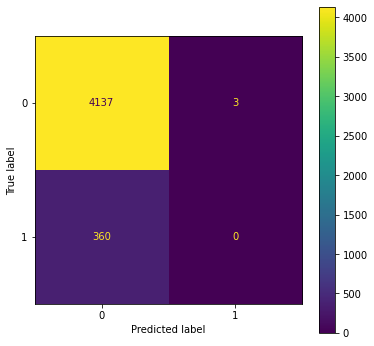

--- ROC AUC ---------------------------------------------------------------------------------------- 



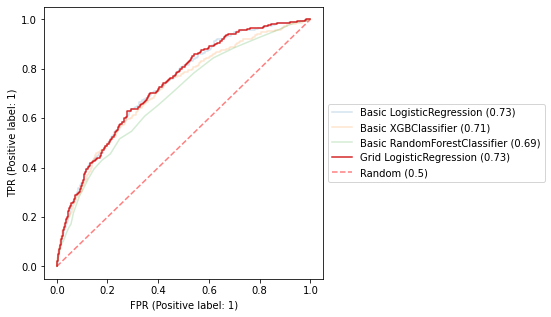

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



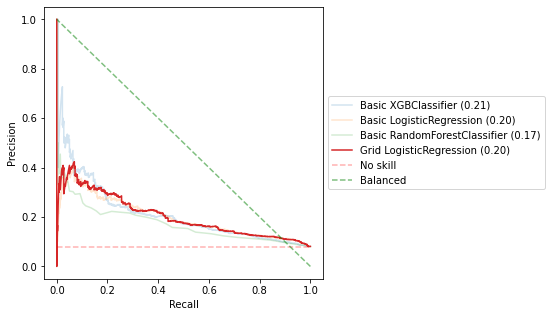

In [71]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [72]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23127962085308057) for this model is reached with a threshold of 0.232


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid LogisticRegression [w/thresholding] -------------------------------------------------------

             ROC_AUC : 0.7338
                  F1 : 0.2230
            ACCURACY : 0.9040
           PRECISION : 0.3163
              RECALL : 0.1722
   AVERAGE_PRECISION : 0.2046

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      4140
Prediction = 1       0.32      0.17      0.22       360

      accuracy                           0.90      4500
     macro avg       0.62      0.57      0.59      4500
  weighted avg       0.88  

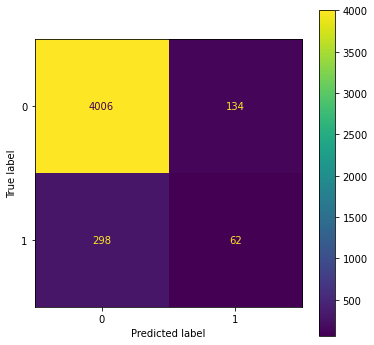

In [73]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [74]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [75]:
model_name = "Grid DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5367
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5371
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5490
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5441
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5003

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5334 (std:0.0449)

----------------------------------------------------------------------------------------------------


In [76]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid DecisionTreeClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6416
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1279

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

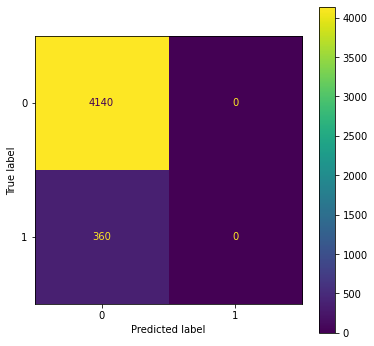

--- ROC AUC ---------------------------------------------------------------------------------------- 



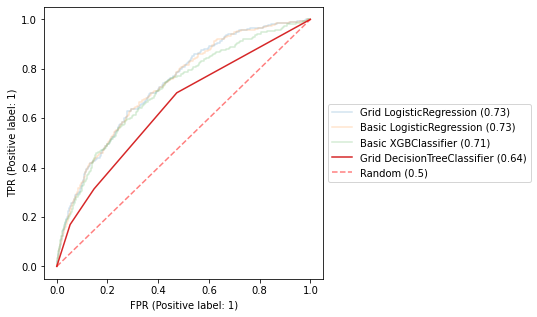

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



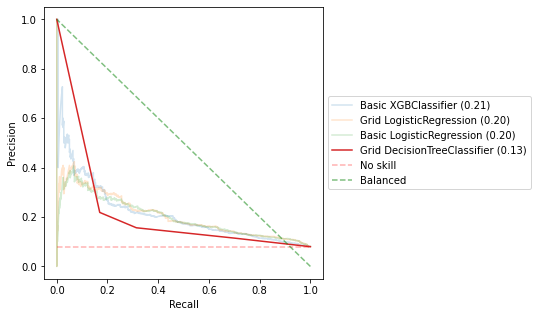

In [77]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [78]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20944444444444446) for this model is reached with a threshold of 0.21


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid DecisionTreeClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6416
                  F1 : 0.1909
            ACCURACY : 0.8851
           PRECISION : 0.2186
              RECALL : 0.1694
   AVERAGE_PRECISION : 0.1279

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      4140
Prediction = 1       0.22      0.17      0.19       360

      accuracy                           0.89      4500
     macro avg       0.57      0.56      0.56      4500
  weighted avg       0.87  

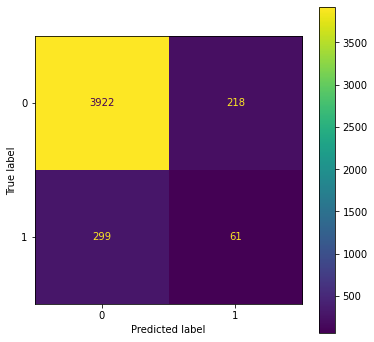

In [79]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [80]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 512]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [81]:
model_name = "Grid RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5875
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6474
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6394
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6603
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6669

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6403 (std:0.0417)

----------------------------------------------------------------------------------------------------


In [82]:
grd_rf['grid'].best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'n_estimators': 400,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid RandomForestClassifier --------------------------------------------------------------------

             ROC_AUC : 0.7148
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1953

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

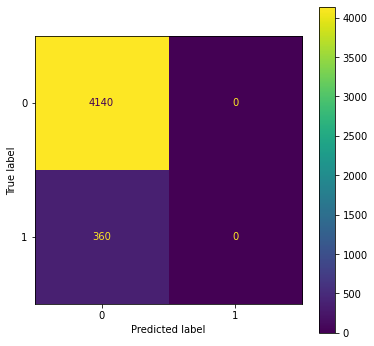

--- ROC AUC ---------------------------------------------------------------------------------------- 



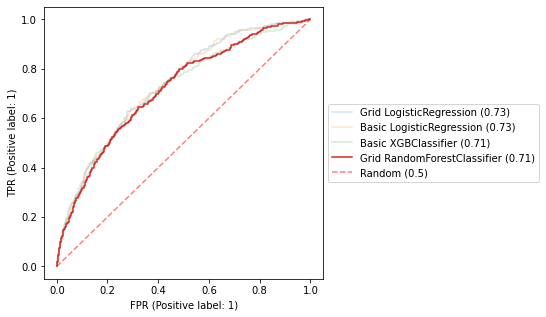

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



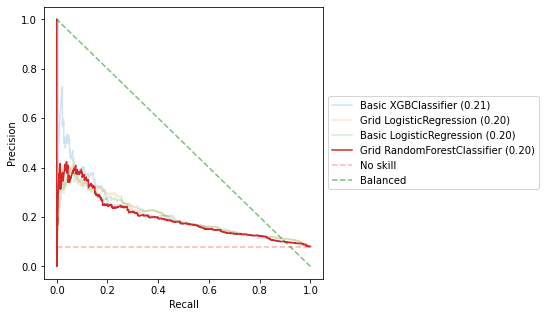

In [83]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédictions *(sur la base du F1 score)*

In [84]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.25867269984917046) for this model is reached with a threshold of 0.258


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid RandomForestClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.7148
                  F1 : 0.1559
            ACCURACY : 0.9158
           PRECISION : 0.3933
              RECALL : 0.0972
   AVERAGE_PRECISION : 0.1953

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.99      0.96      4140
Prediction = 1       0.39      0.10      0.16       360

      accuracy                           0.92      4500
     macro avg       0.66      0.54      0.56      4500
  weighted avg       0.88  

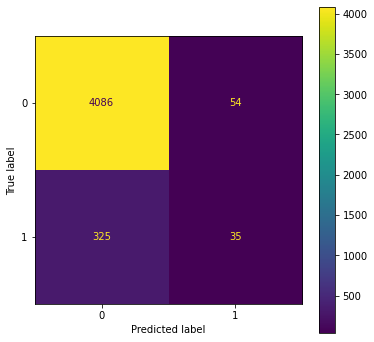

In [85]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [86]:
from xgboost import XGBClassifier

In [87]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [88]:
model_name = "Grid XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6471
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6876
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6286
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6920
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6654

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6641 (std:0.0417)

----------------------------------------------------------------------------------------------------


In [89]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid XGBClassifier -----------------------------------------------------------------------------

             ROC_AUC : 0.7228
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2059

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

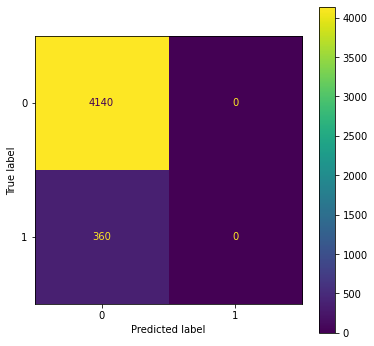

--- ROC AUC ---------------------------------------------------------------------------------------- 



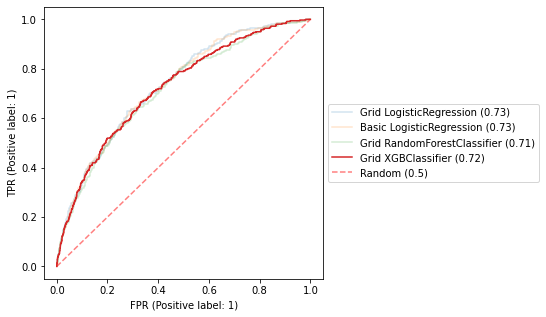

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



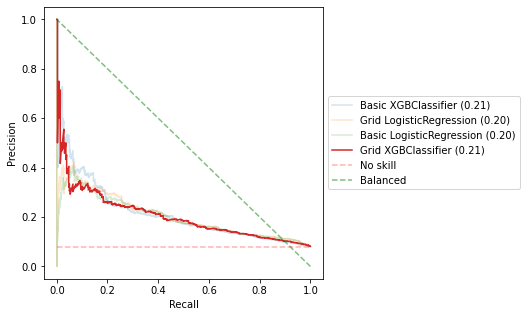

In [90]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [91]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21889870836165876) for this model is reached with a threshold of 0.218


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid XGBClassifier [w/thresholding] ------------------------------------------------------------

             ROC_AUC : 0.7228
                  F1 : 0.1840
            ACCURACY : 0.9073
           PRECISION : 0.3113
              RECALL : 0.1306
   AVERAGE_PRECISION : 0.2059

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      4140
Prediction = 1       0.31      0.13      0.18       360

      accuracy                           0.91      4500
     macro avg       0.62      0.55      0.57      4500
  weighted avg       0.88  

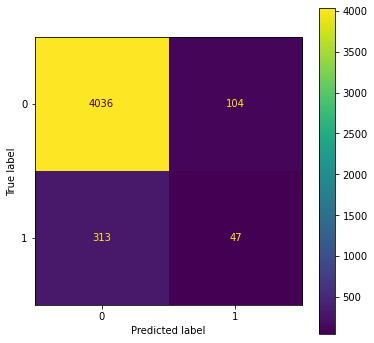

In [92]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. KNN *(k-nearest neighbors)* Grid <a class="anchor" id="models_knn_grid"></a> [⇪](#menu)

In [93]:
param_grid = {
    'n_neighbors': list(range(1,35,2)), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
}

In [94]:
model_name = "Grid KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4486
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5478
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5579
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5541
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5308

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5278 (std:0.0627)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid KNeighborsClassifier ----------------------------------------------------------------------

             ROC_AUC : 0.6058
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1105

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

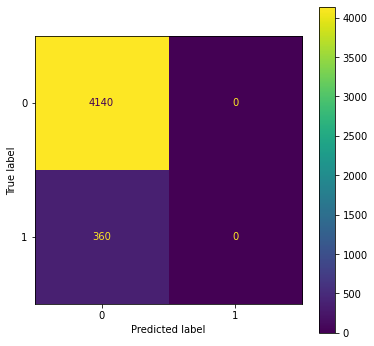

--- ROC AUC ---------------------------------------------------------------------------------------- 



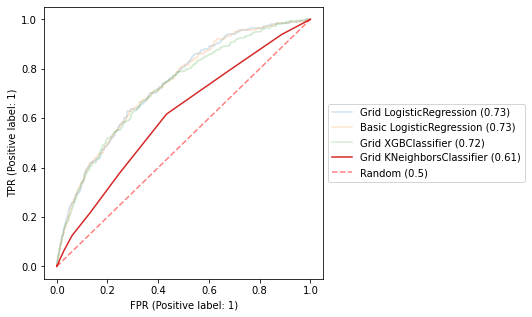

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



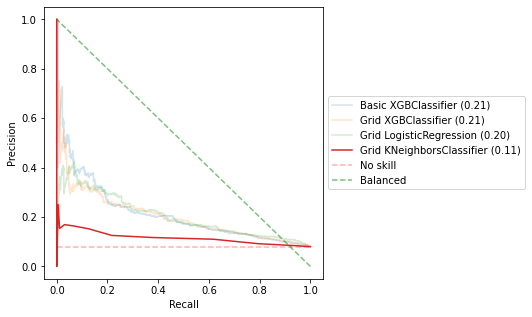

In [95]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [96]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24134256792754397) for this model is reached with a threshold of 0.181


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid KNeighborsClassifier [w/thresholding] -----------------------------------------------------

             ROC_AUC : 0.6058
                  F1 : 0.1374
            ACCURACY : 0.8744
           PRECISION : 0.1525
              RECALL : 0.1250
   AVERAGE_PRECISION : 0.1105

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.94      0.93      4140
Prediction = 1       0.15      0.12      0.14       360

      accuracy                           0.87      4500
     macro avg       0.54      0.53      0.53      4500
  weighted avg       0.86  

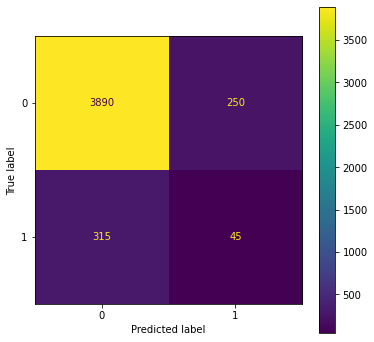

In [97]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Revue des scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [98]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Grid')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
11,Grid LogisticRegression,0.733814,0.0,0.0
13,Grid DecisionTreeClassifier,0.641568,0.0,0.0
15,Grid RandomForestClassifier,0.714838,0.0,0.0
17,Grid XGBClassifier,0.722834,0.0,0.0
19,Grid KNeighborsClassifier,0.605833,0.0,0.0


In [99]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Grid')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
12,Grid LogisticRegression [w/thresholding],0.733814,0.223022,0.172222
14,Grid DecisionTreeClassifier [w/thresholding],0.641568,0.190923,0.169444
16,Grid RandomForestClassifier [w/thresholding],0.714838,0.155902,0.097222
18,Grid XGBClassifier [w/thresholding],0.722834,0.183953,0.130556
20,Grid KNeighborsClassifier [w/thresholding],0.605833,0.137405,0.125000


In [100]:
sms.send("Gridsearch done", stop=False)

# Amélioration des modèles avec `class_weight` pour contre balancer le déséquilibrage des classes <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Logistic Regression balanced with `class_weight` + Grid search<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [101]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [102]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5066
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6433
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6212
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6095
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6234

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6008 (std:0.0589)

----------------------------------------------------------------------------------------------------


In [103]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression --------------------------------------------------------------------

             ROC_AUC : 0.7309
                  F1 : 0.2433
            ACCURACY : 0.6751
           PRECISION : 0.1495
              RECALL : 0.6528
   AVERAGE_PRECISION : 0.2002

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

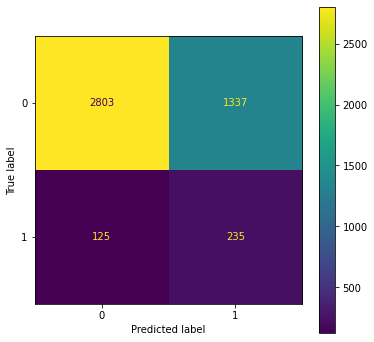

--- ROC AUC ---------------------------------------------------------------------------------------- 



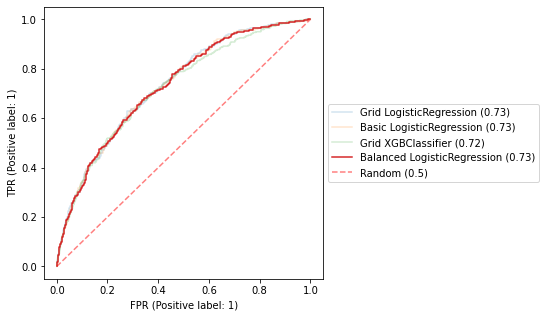

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



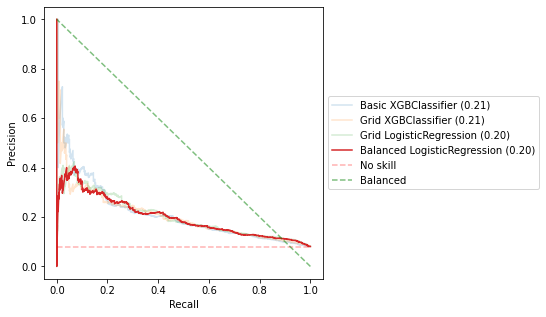

In [104]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [105]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2492853058890795) for this model is reached with a threshold of 0.456


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.7309
                  F1 : 0.2287
            ACCURACY : 0.6178
           PRECISION : 0.1364
              RECALL : 0.7083
   AVERAGE_PRECISION : 0.2002

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.61      0.75      4140
Prediction = 1       0.14      0.71      0.23       360

      accuracy                           0.62      4500
     macro avg       0.55      0.66      0.49      4500
  weighted avg       0.89  

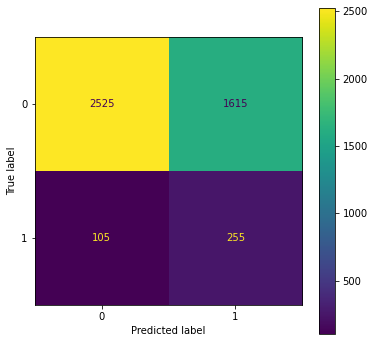

In [106]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree balanced with `class_weight` + Grid search <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [107]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [108]:
model_name = "Balanced DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5527
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5607
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5681
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5604
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5352

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5554 (std:0.0450)

----------------------------------------------------------------------------------------------------


In [109]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier ----------------------------------------------------------------

             ROC_AUC : 0.6797
                  F1 : 0.2322
            ACCURACY : 0.6958
           PRECISION : 0.1455
              RECALL : 0.5750
   AVERAGE_PRECISION : 0.1417

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      4140
Prediction = 1       0.15      0.57      0.23       360

      accuracy                           0.70      4500
     macro avg       0.55      0.64      0.52      4500
  weighted avg       0.89  

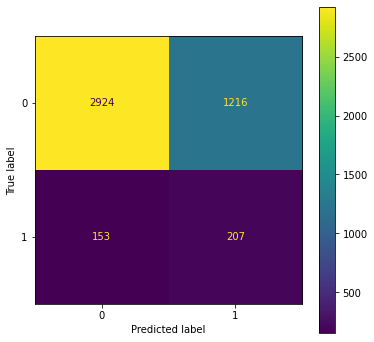

--- ROC AUC ---------------------------------------------------------------------------------------- 



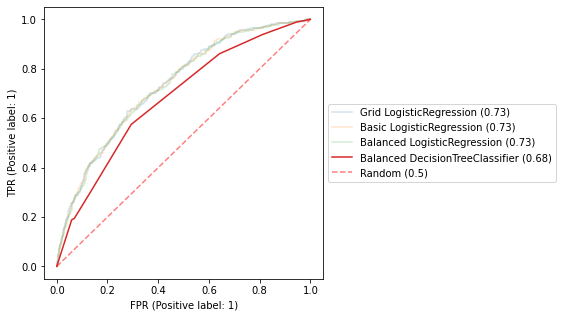

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



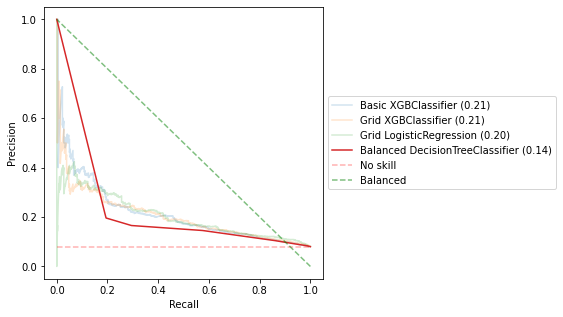

In [110]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [111]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24657816198415147) for this model is reached with a threshold of 0.424


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier [w/thresholding] -----------------------------------------------

             ROC_AUC : 0.6797
                  F1 : 0.2322
            ACCURACY : 0.6958
           PRECISION : 0.1455
              RECALL : 0.5750
   AVERAGE_PRECISION : 0.1417

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      4140
Prediction = 1       0.15      0.57      0.23       360

      accuracy                           0.70      4500
     macro avg       0.55      0.64      0.52      4500
  weighted avg       0.89  

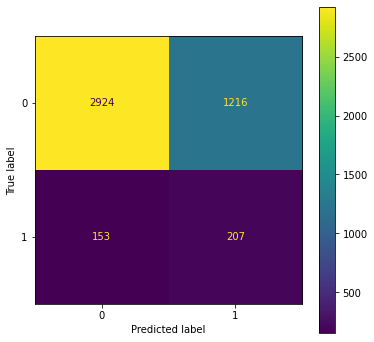

In [112]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest balanced with `class_weight` + Grid search<a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [113]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [114]:
model_name = "Balanced RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6034
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6654
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7086
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6363
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7482

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6724 (std:0.0652)

----------------------------------------------------------------------------------------------------


In [115]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'n_estimators': 300,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier ----------------------------------------------------------------

             ROC_AUC : 0.7035
                  F1 : 0.2294
            ACCURACY : 0.6776
           PRECISION : 0.1418
              RECALL : 0.6000
   AVERAGE_PRECISION : 0.1945

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.68      0.80      4140
Prediction = 1       0.14      0.60      0.23       360

      accuracy                           0.68      4500
     macro avg       0.55      0.64      0.51      4500
  weighted avg       0.89  

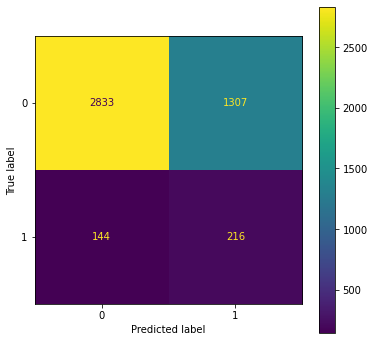

--- ROC AUC ---------------------------------------------------------------------------------------- 



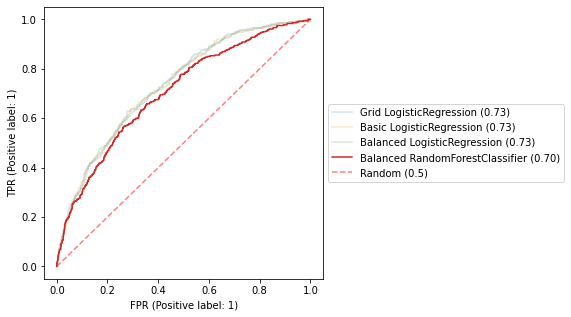

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



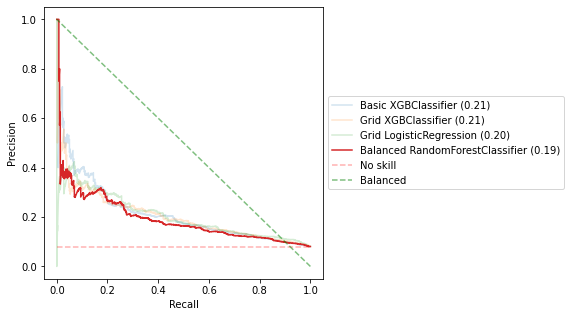

In [116]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [117]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22430036021058464) for this model is reached with a threshold of 0.425


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier [w/thresholding] -----------------------------------------------

             ROC_AUC : 0.7035
                  F1 : 0.2074
            ACCURACY : 0.5398
           PRECISION : 0.1203
              RECALL : 0.7528
   AVERAGE_PRECISION : 0.1945

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.52      0.68      4140
Prediction = 1       0.12      0.75      0.21       360

      accuracy                           0.54      4500
     macro avg       0.54      0.64      0.44      4500
  weighted avg       0.89  

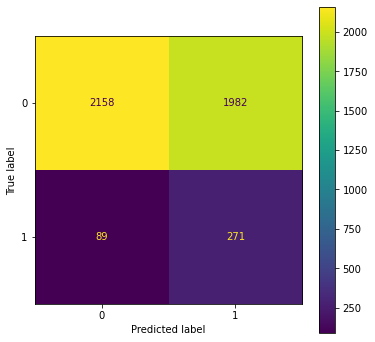

In [118]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier balanced with `class_weight` + Grid search<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [119]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [120]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [121]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6380
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6588
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7213
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6603
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6884

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6734 (std:0.0455)

----------------------------------------------------------------------------------------------------


In [122]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier -------------------------------------------------------------------------

             ROC_AUC : 0.7221
                  F1 : 0.2448
            ACCURACY : 0.6833
           PRECISION : 0.1513
              RECALL : 0.6417
   AVERAGE_PRECISION : 0.2061

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.80      4140
Prediction = 1       0.15      0.64      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

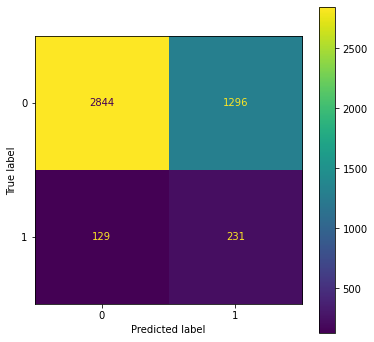

--- ROC AUC ---------------------------------------------------------------------------------------- 



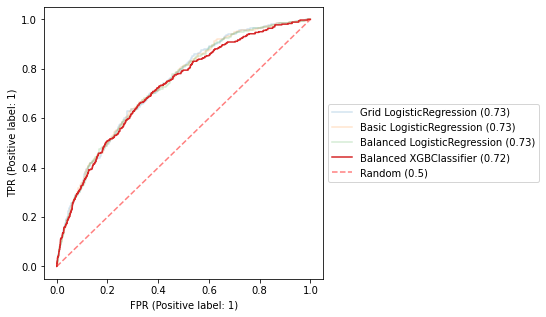

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



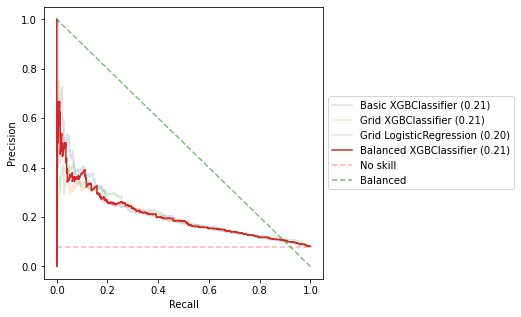

In [123]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [124]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.1880050627981696) for this model is reached with a threshold of 0.321


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding] --------------------------------------------------------

             ROC_AUC : 0.7221
                  F1 : 0.1800
            ACCURACY : 0.3320
           PRECISION : 0.0998
              RECALL : 0.9167
   AVERAGE_PRECISION : 0.2061

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.28      0.44      4140
Prediction = 1       0.10      0.92      0.18       360

      accuracy                           0.33      4500
     macro avg       0.54      0.60      0.31      4500
  weighted avg       0.90  

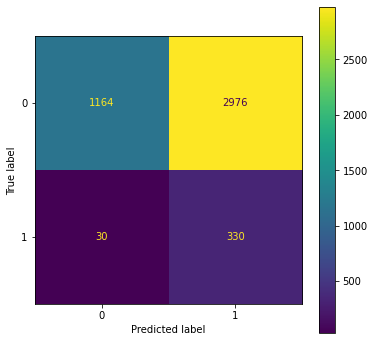

In [125]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [126]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.652778
23,Balanced DecisionTreeClassifier,0.679716,0.232193,0.575000
25,Balanced RandomForestClassifier,0.703471,0.229421,0.600000
27,Balanced XGBClassifier,0.722080,0.244833,0.641667


In [127]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.708333
24,Balanced DecisionTreeClassifier [w/thresholding],0.679716,0.232193,0.575000
26,Balanced RandomForestClassifier [w/thresholding],0.703471,0.207424,0.752778
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.916667


In [128]:
sms.send("Balanced done", stop=False)

# Amélioration des modèles avec `SMOT` pour contre balancer le déséquilibrage des classes <a class="anchor" id="models_smot"></a> [⇪](#menu)

In [168]:
from imblearn.over_sampling import SMOTE

In [169]:
#Use SMOTE to oversample the minority class
oversample = SMOTE(random_state=0)
over_x_train, over_y_train = oversample.fit_resample(X_train,y_train)

In [170]:
over_y_train.value_counts()

1    23457
0    23457
Name: TARGET, dtype: int64

In [171]:
y_test.value_counts()

0    4140
1     360
Name: TARGET, dtype: int64

## 1. Logistic Regression balanced with `SMOT` + Grid search<a class="anchor" id="models_linear_smot"></a> [⇪](#menu)

In [172]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [173]:
model_name = "SMOT LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6797
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6848
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6603
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6708
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6877

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6767 (std:0.0310)

----------------------------------------------------------------------------------------------------


In [174]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT LogisticRegression ------------------------------------------------------------------------

             ROC_AUC : 0.7226
                  F1 : 0.2324
            ACCURACY : 0.6844
           PRECISION : 0.1443
              RECALL : 0.5972
   AVERAGE_PRECISION : 0.1922



/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.69      0.80      4140
Prediction = 1       0.14      0.60      0.23       360

      accuracy                           0.68      4500
     macro avg       0.55      0.64      0.52      4500
  weighted avg       0.89      0.68      0.76      4500

--- Confusion Matrix ------------------------------------------------------------------------------- 



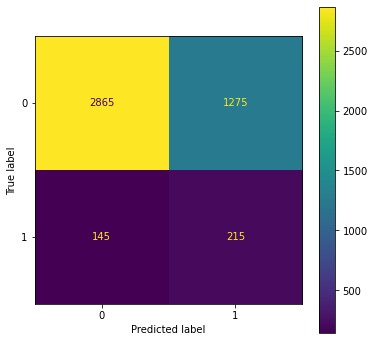

--- ROC AUC ---------------------------------------------------------------------------------------- 



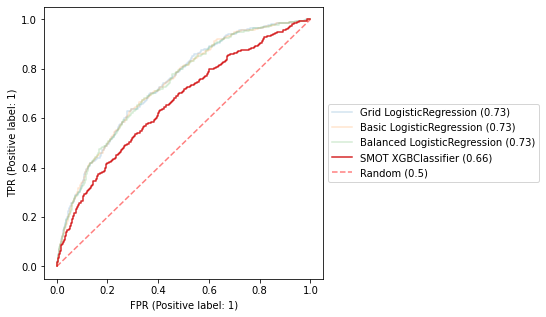

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



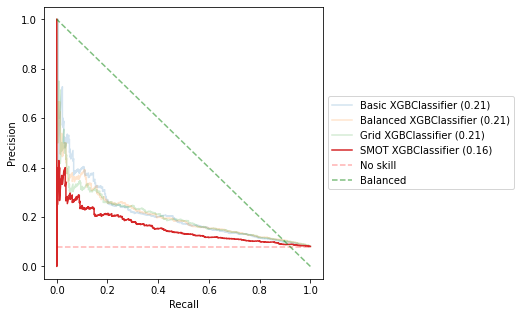

In [175]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [176]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22623679822123408) for this model is reached with a threshold of 0.378


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT LogisticRegression [w/thresholding] -------------------------------------------------------

             ROC_AUC : 0.7226
                  F1 : 0.2180
            ACCURACY : 0.5504
           PRECISION : 0.1266
              RECALL : 0.7833
   AVERAGE_PRECISION : 0.1922

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.53      0.68      4140
Prediction = 1       0.13      0.78      0.22       360

      accuracy                           0.55      4500
     macro avg       0.55      0.66      0.45      4500
  weighted avg       0.90  

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


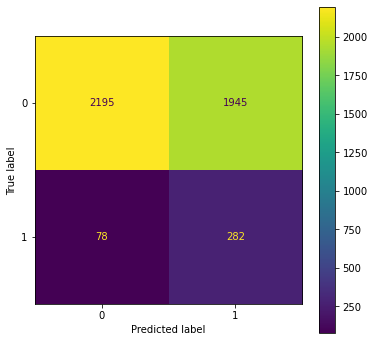

In [177]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree balanced with `SMOT` + Grid search <a class="anchor" id="models_decision_tree_smot"></a> [⇪](#menu)

In [178]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [179]:
model_name = "SMOT DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6703
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6810
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6620
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6638
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6763

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6707 (std:0.0318)

----------------------------------------------------------------------------------------------------


In [180]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT DecisionTreeClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6132
                  F1 : 0.1701
            ACCURACY : 0.7484
           PRECISION : 0.1155
              RECALL : 0.3222
   AVERAGE_PRECISION : 0.1106

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.79      0.85      4140
Prediction = 1       0.12      0.32      0.17       360

      accuracy                           0.75      4500
     macro avg       0.52      0.55      0.51      4500
  weighted avg       0.87  

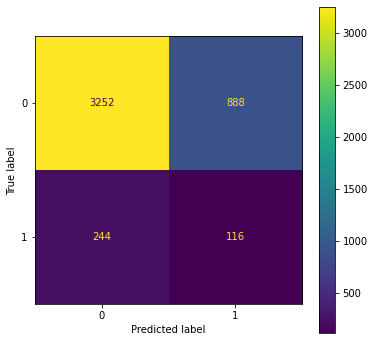

--- ROC AUC ---------------------------------------------------------------------------------------- 



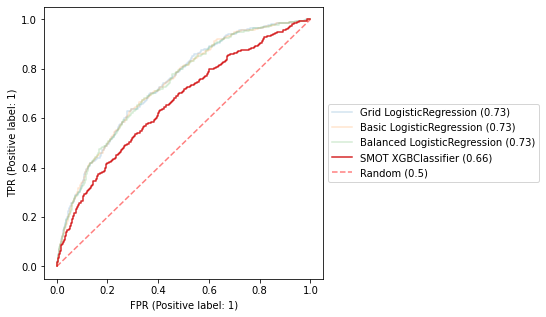

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



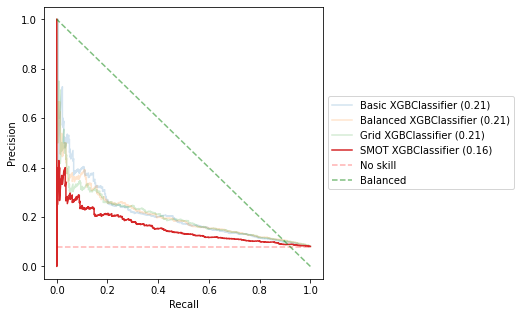

In [181]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [182]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22908450113283546) for this model is reached with a threshold of 0.3


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT DecisionTreeClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6132
                  F1 : 0.1900
            ACCURACY : 0.6098
           PRECISION : 0.1139
              RECALL : 0.5722
   AVERAGE_PRECISION : 0.1106

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.61      0.74      4140
Prediction = 1       0.11      0.57      0.19       360

      accuracy                           0.61      4500
     macro avg       0.53      0.59      0.47      4500
  weighted avg       0.88  

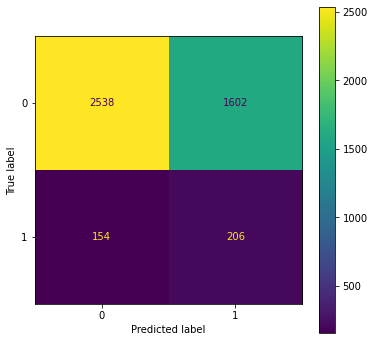

In [183]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. KNN *(k-nearest neighbors)* with `SMOT` + Grid search <a class="anchor" id="models_knn_smot"></a> [⇪](#menu)

In [184]:
param_grid = {
    'n_neighbors': list(range(1,35,2)), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
}

In [185]:
model_name = "SMOT KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6312
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6068
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5724
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6447
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5989

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6108 (std:0.0328)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT KNeighborsClassifier ----------------------------------------------------------------------

             ROC_AUC : 0.6122
                  F1 : 0.1687
            ACCURACY : 0.3649
           PRECISION : 0.0942
              RECALL : 0.8056
   AVERAGE_PRECISION : 0.1102

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.33      0.49      4140
Prediction = 1       0.09      0.81      0.17       360

      accuracy                           0.36      4500
     macro avg       0.52      0.57      0.33      4500
  weighted avg       0.88  

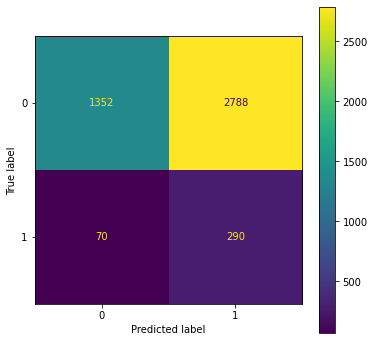

--- ROC AUC ---------------------------------------------------------------------------------------- 



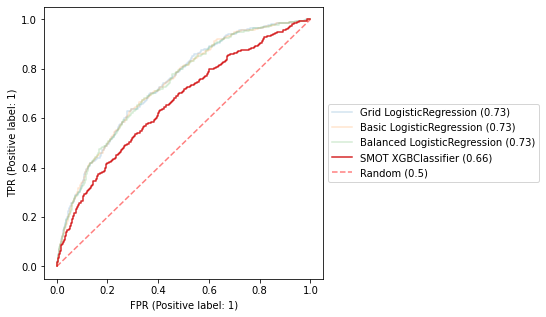

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



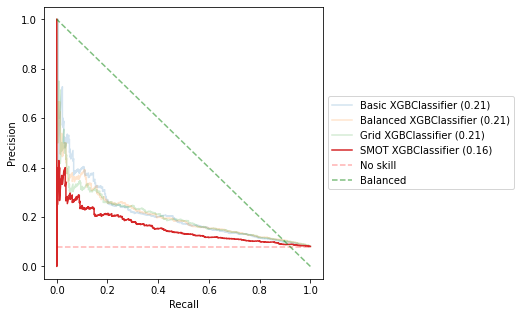

In [186]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [187]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22807228915662653) for this model is reached with a threshold of 0.549


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT KNeighborsClassifier [w/thresholding] -----------------------------------------------------

             ROC_AUC : 0.6122
                  F1 : 0.1777
            ACCURACY : 0.4489
           PRECISION : 0.1009
              RECALL : 0.7444
   AVERAGE_PRECISION : 0.1102

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.42      0.59      4140
Prediction = 1       0.10      0.74      0.18       360

      accuracy                           0.45      4500
     macro avg       0.53      0.58      0.38      4500
  weighted avg       0.88  

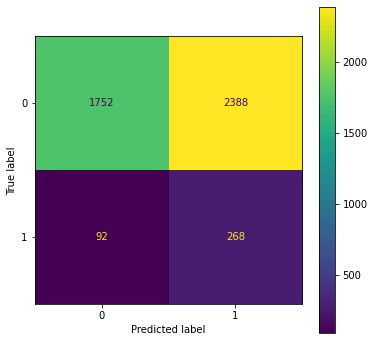

In [188]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Random Forest balanced with `SMOT` + Grid search<a class="anchor" id="models_random_forest_smot"></a> [⇪](#menu)

In [189]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [190]:
model_name = "SMOT RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.8978
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9212
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.8757
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8799
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.9018

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.8953 (std:0.0227)

----------------------------------------------------------------------------------------------------


In [191]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 500,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT RandomForestClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6885
                  F1 : 0.0369
            ACCURACY : 0.9189
           PRECISION : 0.3684
              RECALL : 0.0194
   AVERAGE_PRECISION : 0.1604

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.37      0.02      0.04       360

      accuracy                           0.92      4500
     macro avg       0.64      0.51      0.50      4500
  weighted avg       0.88  

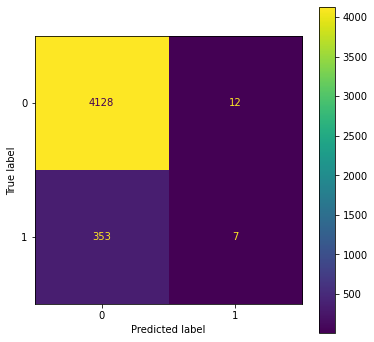

--- ROC AUC ---------------------------------------------------------------------------------------- 



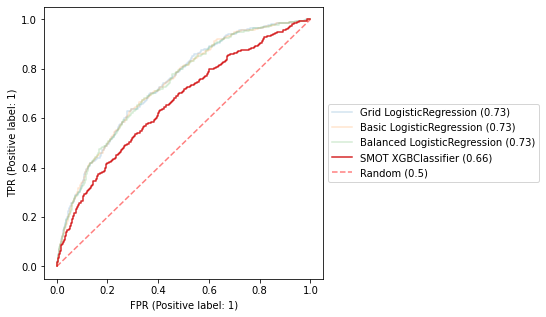

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



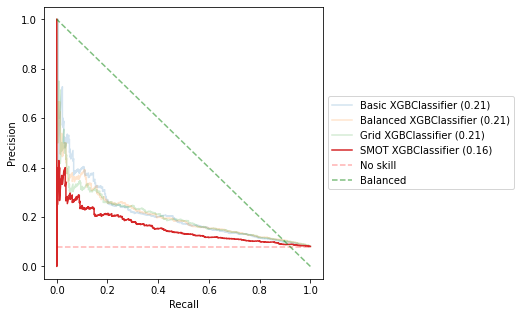

In [192]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [193]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7813898001789442) for this model is reached with a threshold of 0.776


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT RandomForestClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6885
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1604

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

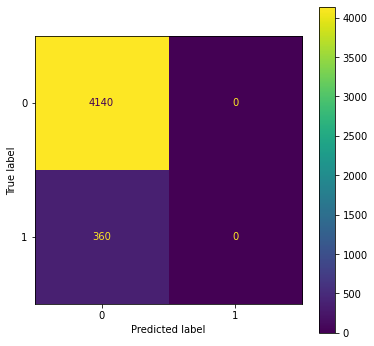

In [194]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 5. XGBoost Classifier balanced with `SMOT` + Grid search<a class="anchor" id="models_xgboost_smot"></a> [⇪](#menu)

In [195]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [196]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [197]:
model_name = "SMOT XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.8915
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9332
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.8652
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8633
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.9084

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.8923 (std:0.0289)

----------------------------------------------------------------------------------------------------


In [198]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 180,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT XGBClassifier -----------------------------------------------------------------------------

             ROC_AUC : 0.6568
                  F1 : 0.2125
            ACCURACY : 0.8682
           PRECISION : 0.2036
              RECALL : 0.2222
   AVERAGE_PRECISION : 0.1573

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.93      4140
Prediction = 1       0.20      0.22      0.21       360

      accuracy                           0.87      4500
     macro avg       0.57      0.57      0.57      4500
  weighted avg       0.87  

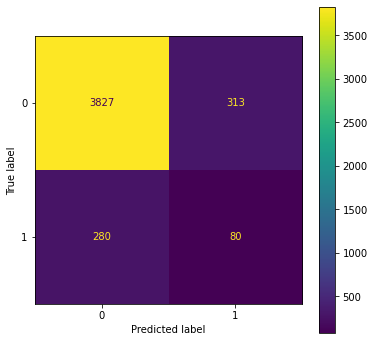

--- ROC AUC ---------------------------------------------------------------------------------------- 



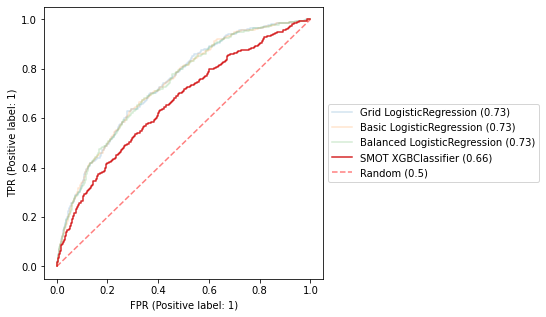

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



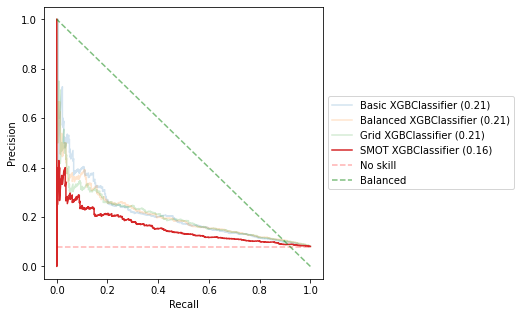

In [199]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [200]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.8817733990147782) for this model is reached with a threshold of 0.879


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT XGBClassifier [w/thresholding] ------------------------------------------------------------

             ROC_AUC : 0.6568
                  F1 : 0.0163
            ACCURACY : 0.9196
           PRECISION : 0.3750
              RECALL : 0.0083
   AVERAGE_PRECISION : 0.1573

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.38      0.01      0.02       360

      accuracy                           0.92      4500
     macro avg       0.65      0.50      0.49      4500
  weighted avg       0.88  

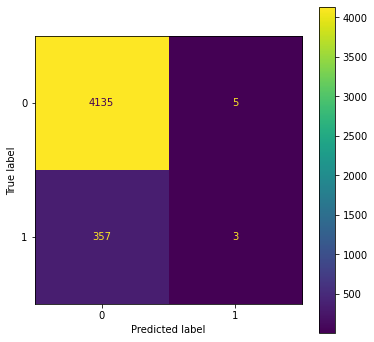

In [201]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [202]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('SMOT')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
29,SMOT LogisticRegression,0.722641,0.232432,0.597222
31,SMOT DecisionTreeClassifier,0.613174,0.170088,0.322222
33,SMOT KNeighborsClassifier,0.612190,0.168703,0.805556
35,SMOT RandomForestClassifier,0.688516,0.036939,0.019444
37,SMOT XGBClassifier,0.656779,0.212483,0.222222


In [203]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('SMOT')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
30,SMOT LogisticRegression [w/thresholding],0.722641,0.218013,0.783333
32,SMOT DecisionTreeClassifier [w/thresholding],0.613174,0.190037,0.572222
34,SMOT KNeighborsClassifier [w/thresholding],0.612190,0.177719,0.744444
36,SMOT RandomForestClassifier [w/thresholding],0.688516,0.000000,0.000000
38,SMOT XGBClassifier [w/thresholding],0.656779,0.016304,0.008333


# Selection des 2 meilleurs modèles pour la suite du projet <a class="anchor" id="models_choice"></a> [⇪](#menu)

## Regardons d'abord l'ensemble des modèles testés

In [204]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.490519,0.078885,0.066578,0.844222,0.063939,0.069444,25,3774,366,335,1.241020,0.003584
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.005464,0.919111,0.166667,0.002778,1,4135,5,359,7.344209,0.025940
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.203866,0.899333,0.277512,0.161111,58,3989,151,302,7.344209,0.008685
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.529593,0.012918
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.529593,0.006264
5,Basic KNeighborsClassifier,None,{},0.541067,0.088950,0.010309,0.914667,0.071429,0.005556,2,4114,26,358,0.258407,6.854248
6,Basic KNeighborsClassifier [w/thresholding],0.389,{},0.541067,0.088950,0.100840,0.881111,0.127660,0.083333,30,3935,205,330,0.258407,3.331389
7,Basic RandomForestClassifier,None,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.784127,0.142599
8,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.784127,0.075645
9,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.713682,0.214494,0.111650,0.918667,0.442308,0.063889,23,4111,29,337,9.182019,0.034857


## A présent, comparons les modèles les plus équilibrés

In [205]:
scores_df[(~scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced|SMOT'))][['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values(['ROC AUC'], ascending=False)

,Method,ROC AUC,F1 score,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.652778
29,SMOT LogisticRegression,0.722641,0.232432,0.597222
27,Balanced XGBClassifier,0.722080,0.244833,0.641667
25,Balanced RandomForestClassifier,0.703471,0.229421,0.600000
35,SMOT RandomForestClassifier,0.688516,0.036939,0.019444
23,Balanced DecisionTreeClassifier,0.679716,0.232193,0.575000
37,SMOT XGBClassifier,0.656779,0.212483,0.222222
31,SMOT DecisionTreeClassifier,0.613174,0.170088,0.322222
33,SMOT KNeighborsClassifier,0.612190,0.168703,0.805556


---
---
>#### A ce stade, les deux meilleurs modèles sur la base du `ROC AUC` (en principal), `Recall` et `F1` sont:
> - la `Balanced LogisticRegression`:
>   - ROC_AUC : 0.7309
>   - F1 : 0.2433
>   - ACCURACY : 0.6751
>   - PRECISION : 0.1495
>   - RECALL : 0.6528
>   - AVERAGE_PRECISION : 0.2002
> - le `Balanced XGBClassifier`:
>   - ROC_AUC : 0.7221
>   - F1 : 0.2448
>   - ACCURACY : 0.6833
>   - PRECISION : 0.1513
>   - RECALL : 0.6417
>   - AVERAGE_PRECISION : 0.2061

>#### Nous allons donc continuer de travailler avec ces deux modèles pour la suite du projet.

---
---

In [206]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting